<a href="https://colab.research.google.com/github/bathiya-94/semEval2024Task_05/blob/main/BERT_with_legal_dataset_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

# Change the current working directory to the desired folder
os.chdir("/content/drive/My Drive/semeval-task-5")

# List the content of the current directory
print(os.listdir())

['dataset_semeval24_traindev', 'test-nb-3.ipynb', 'dataset-train-dev-semeval24.tar.gz', 'train.csv', 'bert-tutorial.ipynb', 'task-5-dataset-playground.ipynb', 'Untitled0.ipynb']


In [4]:
import tarfile
file = tarfile.open('dataset-train-dev-semeval24.tar.gz', 'r:gz')
print(file.getnames())

['dataset_semeval24_traindev', 'dataset_semeval24_traindev/README.md', 'dataset_semeval24_traindev/dev.csv', 'dataset_semeval24_traindev/train.csv']


In [5]:
with tarfile.open('dataset-train-dev-semeval24.tar.gz', 'r:gz') as tar:
   tar.extractall()

In [6]:
import pandas as pd

# file_path = os.path.join('dataset-train-dev-semeval24.tar.gz', 'dev.csv')

# Load the CSV file into a DataFrame
dev_df = pd.read_csv('dataset_semeval24_traindev/dev.csv')

# View the contents of the DataFrame
dev_df.head(5)

,idx,question,answer,label,analysis,complete analysis,explanation
0,0,7. A venue medley. Zirkhov brings a diversity ...,The court must transfer the action to the West...,0,C suggests that the judge must transfer under ...,A good place to start is to ask whether venue ...,"So, when a plaintiff files suit in a district ..."
1,1,7. A venue medley. Zirkhov brings a diversity ...,"The court will have to dismiss, since 28 U.S.C...",0,"Nibbling away at the edges, consider D, which ...",A good place to start is to ask whether venue ...,"So, when a plaintiff files suit in a district ..."
2,2,7. A venue medley. Zirkhov brings a diversity ...,The court could transfer the action under 28 U...,0,A good place to start is to ask whether venue ...,A good place to start is to ask whether venue ...,"So, when a plaintiff files suit in a district ..."
3,3,7. Comedy of errors. Laurel and Hardy are inju...,"reverse the decision in Fields’s case, and rem...",0,In this example the federal judge did her best...,In this example the federal judge did her best...,State law is not static. It may change while a...
4,4,7. Comedy of errors. Laurel and Hardy are inju...,"reverse the decision in Fields’s case, and rem...",1,But what will the federal trial court do about...,In this example the federal judge did her best...,State law is not static. It may change while a...


In [7]:
# Load the CSV file into a DataFrame
train_df = pd.read_csv('dataset_semeval24_traindev/train.csv')

# View the contents of the DataFrame
print(train_df.columns)

Index(['idx', 'question', 'answer', 'label', 'analysis', 'complete analysis',
       'explanation'],
      dtype='object')


In [8]:
train_df.head(5)

,idx,question,answer,label,analysis,complete analysis,explanation
0,0,"1. Redistricting. Dziezek, who resides in the ...",the Western District of Kentucky.,0,So the remaining question is whether the West...,"Let’s see. Under §1391(b)(1), venue is proper ...",Venue in most federal actions is governed by 2...
1,1,"1. Redistricting. Dziezek, who resides in the ...",the Southern District of Indiana.,0,But B is clearly not: the plaintiff’s residenc...,"Let’s see. Under §1391(b)(1), venue is proper ...",Venue in most federal actions is governed by 2...
2,2,"1. Redistricting. Dziezek, who resides in the ...",the Southern District of Ohio.,1,"Let’s see. Under §1391(b)(1), venue is proper ...","Let’s see. Under §1391(b)(1), venue is proper ...",Venue in most federal actions is governed by 2...
3,3,"2. Venue exercises. Chu, a Californian, went s...",proper in the Southern District of California ...,0,A is pretty clearly wrong. Although §1391(b)(2...,This question didn’t give my students much tro...,The venue provisions in §1391(b) also apply in...
4,4,"2. Venue exercises. Chu, a Californian, went s...",proper in the District of Colorado under §1391...,0,"B is another loser. First of all, Jackson does...",This question didn’t give my students much tro...,The venue provisions in §1391(b) also apply in...


In [9]:
counts = train_df['label'].value_counts()
print(counts)

0    505
1    161
Name: label, dtype: int64


In [10]:
train_df['CONTEXT'] = train_df['question'] + ". " + train_df['answer']
train_df.head(5)
train_df.drop(labels=['idx', 'question', 'answer', 'analysis', 'complete analysis',
       'explanation'], axis = 1, inplace=True)
train_df.columns

Index(['label', 'CONTEXT'], dtype='object')

In [11]:
train_df = train_df[['CONTEXT', 'label' ]]
train_df.head()

,CONTEXT,label
0,"1. Redistricting. Dziezek, who resides in the ...",0
1,"1. Redistricting. Dziezek, who resides in the ...",0
2,"1. Redistricting. Dziezek, who resides in the ...",1
3,"2. Venue exercises. Chu, a Californian, went s...",0
4,"2. Venue exercises. Chu, a Californian, went s...",0


In [12]:
train_text, temp_text, train_labels, temp_labels = train_test_split(train_df['CONTEXT'], train_df['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=train_df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

<Axes: >

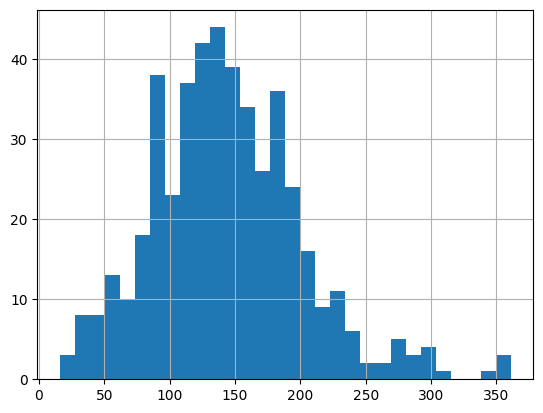

In [13]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [14]:
max_seq_len = 512

# Tokenizer and Model

In [28]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased', return_dict=False)

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [29]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [30]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Create Data Loaders

In [31]:

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# BERT model

In [32]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

## Model Architecture

In [33]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):

      super(BERT_Arch, self).__init__()

      self.bert = bert

      # dropout layer
      self.dropout = nn.Dropout(0.1)

      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model
      _, cls_hs = self.bert(sent_id, attention_mask=mask)

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      # apply softmax activation
      x = self.softmax(x)

      return x

In [34]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [35]:
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [41]:

# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Model Weights

In [36]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
# class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

class_wts = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels
                                    )

print(class_wts)

[0.66005666 2.0619469 ]


In [37]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 10

In [38]:
# function to train the model
def train():

  model.train()

  total_loss, total_accuracy = 0, 0

  # empty list to save model predictions
  total_preds=[]

  # iterate over batches
  for step,batch in enumerate(train_dataloader):

    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]

    sent_id, mask, labels = batch

    # clear previously calculated gradients
    model.zero_grad()

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
      # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds


In [39]:

# function for evaluating the model
def evaluate():

  print("\nEvaluating...")

  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0

  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):

    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:

      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)

      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():

      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [42]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')



 Epoch 1 / 10

Evaluating...

Training Loss: 0.813
Validation Loss: 0.676

 Epoch 2 / 10

Evaluating...

Training Loss: 0.711
Validation Loss: 0.742

 Epoch 3 / 10

Evaluating...

Training Loss: 0.739
Validation Loss: 0.772

 Epoch 4 / 10

Evaluating...

Training Loss: 0.711
Validation Loss: 0.730

 Epoch 5 / 10

Evaluating...

Training Loss: 0.716
Validation Loss: 0.686

 Epoch 6 / 10

Evaluating...

Training Loss: 0.731
Validation Loss: 0.684

 Epoch 7 / 10

Evaluating...

Training Loss: 0.704
Validation Loss: 0.679

 Epoch 8 / 10

Evaluating...

Training Loss: 0.723
Validation Loss: 0.683

 Epoch 9 / 10

Evaluating...

Training Loss: 0.701
Validation Loss: 0.690

 Epoch 10 / 10

Evaluating...

Training Loss: 0.712
Validation Loss: 0.738


In [43]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [45]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [46]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.75      0.89      0.81        76
           1       0.11      0.04      0.06        24

    accuracy                           0.69       100
   macro avg       0.43      0.47      0.44       100
weighted avg       0.59      0.69      0.63       100



In [47]:
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,68,8
1,23,1
